В настоящей работе представлен анализ датасета, расположенного по ссылке 
$$https://drive.google.com/file/d/1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC/view$$

**Задание 1:** 
<i>Выберите 10 аэропортов, в которые чаще всего летают из Нью-Йорка. Для каждого  из них оцените вероятность, что рейс прилетит с положительной задержкой (arr_delay > 0) и постройте график (столбчатая диаграмма), на котором по оси х – название аэропорта, по оси y – вероятность задержки прилета. Названия аэропортов по оси х расположите слева направо по убыванию количества рейсов в этот аэропорт. Для какого аэропорта из этих 10 вероятность окажется наибольшей, и для какого – наименьшей? <i>

In [255]:
#для начала импортируем все необходимые для данного задания библиотеки, в дальнейшем будем импортировать другие по мере необходимости
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt

Импортируем данные и подготавливаем данные

In [256]:
#импорт датасета
dff = pd.read_csv("https://drive.google.com/uc?id=1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC")
# удаляем все строчки, в которых есть хотя бы какие-то пустоты
df = dff.dropna()
df = dff.dropna(subset=['arr_delay', 'origin', 'dest', 'air_time', 'tailnum', 'dep_time', 'arr_time'])
nyc_airpts = ['JFK', 'LGA', 'EWR']
#датасет, с рейсами из аэропортов Нью-Йорка
nyc_flights = df[df['origin'].isin(nyc_airpts)]
#считаем количество рейсов, чтобы отыскать 10 наиболее популярных арэропортов, в которые летают из Нью-Йорка
dest_counts = nyc_flights['dest'].value_counts()
top10_dest = dest_counts.head(10)
#подготавливаем словарь для записи значений вероятности того, что рейс прилетит с положительной задержкой
prob_dict = {}

Вероятность будет считать частотным методом.
Пройдясь по всем наиболее популярным аэропортам, в которые летают из Нью-Йорка.

In [257]:
for airport in list(top10_dest.index):
    flights_to_airport = nyc_flights[nyc_flights['dest']==airport]
    flights_with_positive_arr_delay = flights_to_airport[flights_to_airport['arr_delay']>0]
    #подсчитываем искомую вероятностью для каждого аэропорта:
    prob_dict.update({airport: flights_with_positive_arr_delay['arr_delay'].shape[0]/flights_to_airport['arr_delay'].shape[0]})

# Преобразуем в DataFrame для удобной сортировки
result_df = pd.DataFrame({
    'airport': top10_dest.index,
    'delay_prob': [prob_dict[ap] for ap in top10_dest.index]
})

Теперь займемся визуализацией данных, и найдем аэропорты с максимальной и минимальной вероятностью задержки.

Наибольшая вероятность задержки: ATL (47.194%)
Наименьшая вероятность задержки: BOS (31.574%)


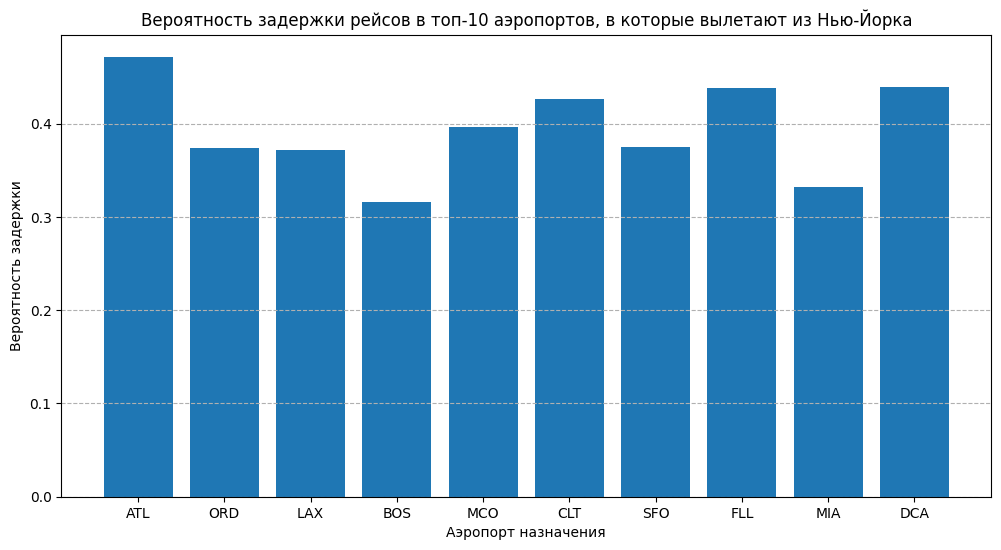

In [258]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.bar(prob_dict.keys(), prob_dict.values())
plt.title('Вероятность задержки рейсов в топ-10 аэропортов, в которые вылетают из Нью-Йорка')
plt.xlabel('Аэропорт назначения')
plt.ylabel('Вероятность задержки')
plt.grid(axis='y', linestyle='--')

# Находим аэропорты с max и min вероятностью задержки
max_prob_row = result_df.loc[result_df['delay_prob'].idxmax()]
min_prob_row = result_df.loc[result_df['delay_prob'].idxmin()]

print(f"Наибольшая вероятность задержки: {max_prob_row['airport']} ({max_prob_row['delay_prob']:.3%})")
print(f"Наименьшая вероятность задержки: {min_prob_row['airport']} ({min_prob_row['delay_prob']:.3%})")

plt.show()


**Вывод:**

Таким образом, На основе анализа 10 наиболее популярных направлений из аэропортов Нью-Йорка, мы получили распределение вероятности задержки от аэропорта назначения.

При этом с наибольшей вероятностью задержки оказался аэропорт **Аталанты (ATL)** c Вероятностью задержки `47.194%`,
а с наименьшей вероятностью - аэропорт **Бостона (BOS)** c вероятностью задержки `31.574%`


------



**Задание 2:**
<i>остройте нормированную гистограмму распределения времени перелета из Нью-Йорка в Сан-Франциско (SFO). Предполагая, что это распределение описывается нормальным законом, оцените параметры нормального закона и наложите график плотности полученного нормального закона на график с гистограммой. В каких пределах с вероятностью не менее 95% лежит время полета?<i>
    


In [259]:
#снова импортируем данные и выбираем необходимые нам рейсы

df = pd.read_csv("https://drive.google.com/uc?id=1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC")
df = df.dropna()
nyc_flights = df.dropna(subset=['arr_delay', 'origin', 'dest', 'air_time', 'tailnum', 'dep_time', 'arr_time'])

sfo_flights = df[(df['origin'].isin(nyc_airpts)) & (df['dest']=='SFO')]
air_time = sfo_flights['air_time']


Займемся статистикой, рассчитаем параметры выборки. Создадим функцию нормального распределения, которая позволит нам наложить теоретический график нормального распределения данных с параметрами выборки на нормированную гистограмму распределения времени перелета из Нью-Йорка в Сан-Франциско.

In [260]:
#рассчитываем параметры распределения
aver = air_time.mean() 
sigma = air_time.std() 
print(f"Среднее время перелёта: {aver:.1f} мин")
print(f"Стандартное отклонение: {sigma:.1f} мин") 

def normal(x, m, sigma):
    return (1/(sigma * math.sqrt(2*math.pi)))*np.exp(-0.5*((x-m)/sigma)**2)

# нормальное распределение строим для значений времени, находящегося на расстоянии от -3 sigm до 3 sigm от среднего\наиболее вероятного значения 
x = np.linspace(aver - 3*sigma, aver + 3*sigma, 500)
y = normal(x, aver, sigma)  # Плотность нормального распределения

Среднее время перелёта: 345.7 мин
Стандартное отклонение: 17.2 мин


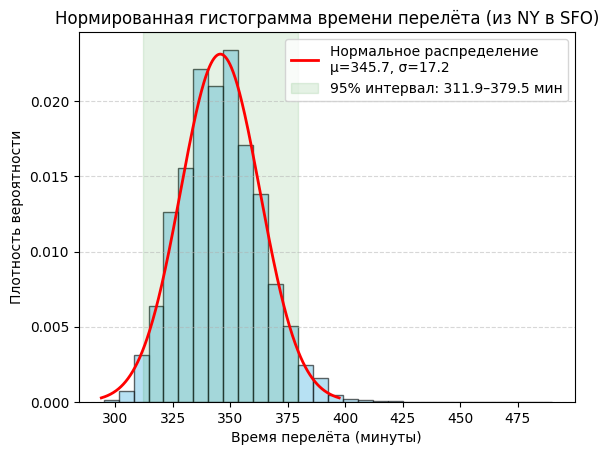

In [261]:
#функция сразу нормирует гистограмму, density=True
plt.hist(air_time, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

plt.title('Нормированная гистограмма времени перелёта (из NY в SFO)')
plt.xlabel('Время перелёта (минуты)')
plt.ylabel('Плотность вероятности')
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Наложение кривой
plt.plot(x, y, 'r-', linewidth=2, label=f'Нормальное распределение\nμ={aver:.1f}, σ={sigma:.1f}')
lower = aver - 1.96*sigma
upper = aver + 1.96*sigma
# выделяем на графике область, в пределах которой время полета лежит с вероятностью 95%
plt.axvspan(lower, upper, color='green', alpha=0.1, 
            label='95% интервал: {:.1f}–{:.1f} мин'.format(lower, upper))
plt.legend()
plt.show()

**Вывод:**

Распределение времени полета из Нью-Йорка в Сан-Франциско приближается к нормальному.  
Параметры оцененного нормального закона:  
- среднее значение: `μ ≈ 345.7` минут  
- стандартное отклонение: `σ ≈ 17.2` минут  

Согласно оценке нормального закона, с вероятностью 95% время полета из Нью-Йорка в Сан-Франциско лежит в пределах от `311.9` до `379.5` минут. Это значит, что отклонения от этих границ можно считать редкими случаями.

Выше предсавлена реализация визуализации данных.

-----


**Задание №3**
<i>Нарисуйте распределение по часам (0-23) количества вылетов из аэропорта JFK и найдите два пиковых часа (один до полудня, другой – после полудня) по количеству вылетов (время вылета переводите в час вылета округлением вниз, например 7:20 -> 7, 16:45 -> 16). Для каждого из двух найденных пиковых часов найдите среднее время задержки вылетов в этот час. Когда средняя задержка больше? Будет ли это различие в средних значениях статистически значимо?<i>
    

In [262]:
#импортируем необходимые для дальнейшего анализа библиотеки
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

In [263]:
#снова импортируем и форматируем данные 
df = pd.read_csv("https://drive.google.com/uc?id=1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC")
df = df.dropna()
airport_jfk = df[df['origin']=="JFK"].copy()
airport_jfk = airport_jfk[(airport_jfk['dep_time'] > 0) & (airport_jfk['dep_time'] < 2400)]
airport_jfk['round_dep_time'] = (airport_jfk['dep_time']//100 ).astype(int)
time_dict = {}

Заполнаяем словарь, который каждому часу от `0` до `23` ставит в соответствие количество рейсов отправленных в это время

In [264]:
for h in range(24):
    count = airport_jfk[airport_jfk['round_dep_time']==float(h)].shape[0]
    time_dict[h] = count

#в словари ниже будем записывать время с максимальным количеством полетов от 0 до 11 и от 12 до 23
max_011_d = {"":0}
max_1223_d = {"":0}

Далее ищем время с максимальным количеством полетов от 0 до 11 и от 12 до 23, после чего найдем среднее значение задержки отправки в разных диапазонах часов.

In [265]:
for i in range(12):
    if time_dict[i] > list(max_011_d.values())[0]:
        max_011_d = {i:time_dict[i]}
for i in range(12,24):
    if time_dict[i] > list(max_1223_d.values())[0]:
        max_1223_d = {i:time_dict[i]}

max_011 = [list(max_011_d.keys())[0], list(max_011_d.values())[0]]
max_1223 = [list(max_1223_d.keys())[0], list(max_1223_d.values())[0]]

mean_011 = airport_jfk[airport_jfk['round_dep_time']==max_011[0]]['dep_delay'].mean()

mean_1223 = airport_jfk[airport_jfk['round_dep_time']==max_1223[0]]['dep_delay'].mean()

print(f"Средняя задержка утром ({max_011[0]}:00): {mean_011:.1f} мин")
print(f"Средняя задержка вечером ({max_1223[0]}:00): {mean_1223:.1f} мин")

Средняя задержка утром (8:00): 1.0 мин
Средняя задержка вечером (16:00): 10.9 мин


In [266]:
#определим, в какой половине дня задержка больше
if mean_011 > mean_1223:
    print("Задержки утром больше.")
else:
    print("Задержки вечером больше.")


Задержки вечером больше.


In [267]:

morning_delays = airport_jfk[airport_jfk['round_dep_time'] == max_011[0]]['dep_delay']
evening_delays = airport_jfk[airport_jfk['round_dep_time'] == max_1223[0]]['dep_delay']
def comp_delays(morning, evening, morning_hour, evening_hour):
    from scipy.stats import mannwhitneyu
    import numpy as np

    # используем Манна-Уитни
    stat, p = mannwhitneyu(morning, evening, alternative='two-sided')
    print(f"\nТест Манна-Уитни: p-value = {p:.4f}")
        
    if p < 0.05:
        print("Различие статистически значимо")
    else:
        print("Различие не статистически значимо")

comp_delays(morning_delays, evening_delays, max_011[0], max_1223[0])


Тест Манна-Уитни: p-value = 0.0000
Различие статистически значимо


**Вывод:**

По результатам работы программы, было выяснено:
На основе анализа вылетов из аэропорта JFK по часам были определены два пиковых часа:  
- до полудня: `8:00`  
- после полудня: `16:00`  

Средняя задержка в час `8` - `1.0` минута, а в час `16` *-* `10.9` минут.  
Задержки вечером значительно больше задержек утром.

Для оценки статистической значимости данных использовался тест Манна-Уитни, он показал, что 
 что различие данных статистически значимо, т.к. параметр p < 0.05, а задержки во второй половине дня оказались больше задержек в первой половине (вечером больше чем утром)

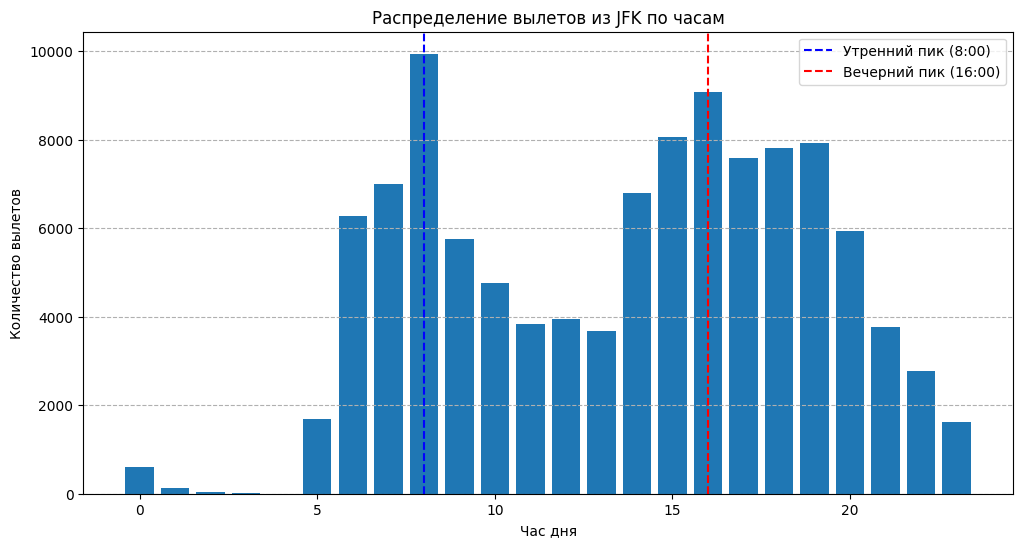

In [268]:
#визуализация данных
plt.figure(figsize=(12, 6))
plt.bar(time_dict.keys(), time_dict.values())
plt.axvline(x=max_011[0], color='blue', linestyle='--', label=f'Утренний пик ({max_011[0]}:00)')
plt.axvline(x=max_1223[0], color='red', linestyle='--', label=f'Вечерний пик ({max_1223[0]}:00)')
plt.xlabel('Час дня')
plt.ylabel('Количество вылетов')
plt.title('Распределение вылетов из JFK по часам')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

-----

**Задание 4:** <i>Для каждого аэропорта прилета найдите величину стандартного отклонения времени перелета. Постройте график (точечная диаграмма) зависимости стандартного отклонения от расстояния до аэропорта. Аппроксимируйте полученную зависимость моделью линейной регрессии на основе расстояния до аэропорта  Добавьте к предыдущему графику график линейной регрессии. Уточните модель линейной регрессии, используя дополнительные входные признаки на основе расстояния до аэропорта. Добавьте график уточненной модели. Сравните точность моделей.<i>

In [269]:
#вновь импортируем необходимые библиотеки
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [270]:
df = pd.read_csv("https://drive.google.com/uc?id=1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC")
df = df.dropna()
df = df.dropna(subset=["air_time", "distance", "dest"])

# Группировка: стандартное отклонение air_time и среднее расстояние до аэропорта
std_airtime = df.groupby("dest")["air_time"].std()
mean_distance = df.groupby("dest")["distance"].mean()

# Объединение в один DataFrame
data = pd.DataFrame({
    "std_airtime": std_airtime,
    "distance": mean_distance
}).dropna()

Форматируем данные для линейной аппроксимации их через библиотеку sklearn

In [271]:
# Подготовка признаков для модели
X = data["distance"].values.reshape(-1, 1)       # 2D массив для sklearn
y = data["std_airtime"].values                   # 1D массив 

# Линейная регрессия
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
data['distance_squared'] = data['distance'] ** 2

Далее создаем уточняющую модель линейной регрессии, где будут учитываться квадраты расстояния между аэропортами.

In [272]:
X_extended = data[['distance', 'distance_squared']].values#.reshape(-1,1)
model_extended = LinearRegression()
model_extended.fit(X_extended, y)
y_pred_extended = model_extended.predict(X_extended)

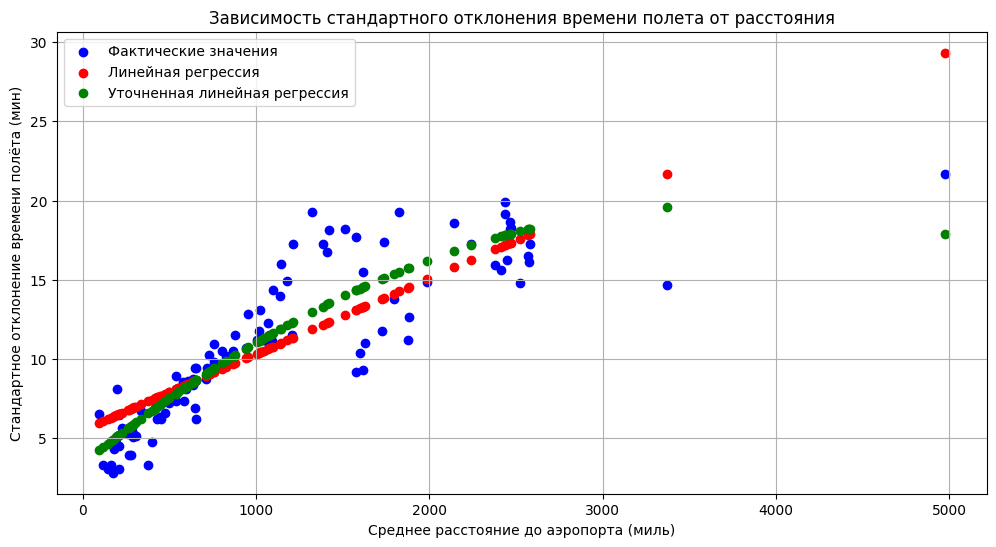

R^2 score (качество линейной модели): 0.7091
R^2 score (качество линейной модели): 0.7984


In [273]:
plt.figure(figsize=(12, 6))
# Фактические значения
plt.scatter(X, y, color='blue', label='Фактические значения')
plt.scatter(X, y_pred, color='red', label='Линейная регрессия')
plt.scatter(X, y_pred_extended, color='green', label='Уточненная линейная регрессия')
plt.xlabel("Среднее расстояние до аэропорта (миль)")
plt.ylabel("Стандартное отклонение времени полёта (мин)")
plt.title("Зависимость стандартного отклонения времени полета от расстояния")
plt.legend()
plt.grid(True)
plt.show()

# оценка точности модели
print(f"R^2 score (качество линейной модели): {r2_score(y, y_pred):.4f}")
print(f"R^2 score (качество линейной модели): {r2_score(y, y_pred_extended):.4f}")

**Вывод:**

Зависимость стандартного отклонения времени полета от расстояния показывает, что разброс времени полета, как правило, увеличивается с расстоянием, но не строго линейно.  
Также была построена уточненная модель, где учитывалось расстояние между аэропортами возведенное в квадрат, такая модель оказалась более точной чем первая модель, котоаря учитывала только расстояние между аэропортами. 

-----

**Задание 5:** <i>Методом кластерного анализа выделите три группы авиакомпаний на основе пары признаков: средняя задержка прилета и средняя задержка вылета. Постройте точечную диаграмму на этих признаках и раскрасьте точки в соответствии с номером кластера. Попробуйте дать интерпретацию кластерам (в этом может помочь название авиакомпании).<i>

In [274]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [275]:
#импорт и очистка данных
df = pd.read_csv("https://drive.google.com/uc?id=1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC")
df = df.dropna()
df = df.dropna(subset=["air_time", "distance", "dest"])

X = df[['dep_delay', 'arr_delay']]

In [276]:
# при помощи библиотеки sklearn осуществляем кластеризацию данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Добавляем идентификаторы кластеров в качестве нового атрибута в исходные данные
df['Cluster'] = kmeans.labels_
cluster_counts = df.groupby(['carrier', 'Cluster']).size()

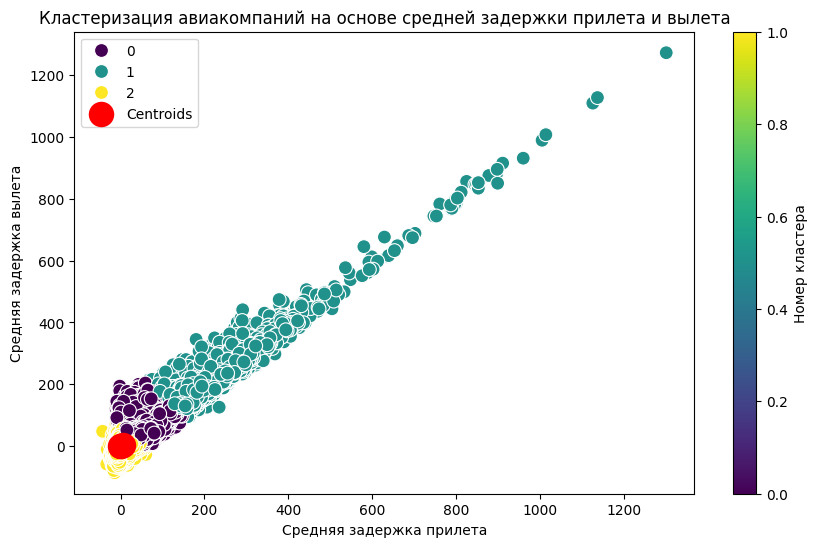

In [279]:
# и визуализируем данные
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['dep_delay'], y=df['arr_delay'], hue=df['Cluster'], palette='viridis', s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Кластеризация авиакомпаний на основе средней задержки прилета и вылета')
plt.xlabel('Средняя задержка прилета')
plt.ylabel('Средняя задержка вылета')
plt.colorbar(label='Номер кластера')
plt.legend()
plt.show()

В результате кластеризации авиакомпаний по двум признакам — средней задержке вылета и средней задержке прилета — удалось выделить три группы:

- **Кластер 2:** Компании с низкими средними задержками как на вылет, так и на прилёт. В процен.
- **Кластер 1:** Компании с высокими задержками, как правило, показывают проблемы с регулярностью — возможно, из-за перегруженности маршрутов или внутренних организационных факторов.
- **Кластер 0:** Промежуточный класс — компании, у которых одна из задержек (например, прилёт) существенно больше, чем другая.

Анализ таких групп может помочь при выборе авиакомпании и при анализе системных проблем в управлении авиаперевозками.


In [ ]:
# Группируем по авиакомпании и кластеру, считаем количество рейсов
cluster_counts = df.groupby(['carrier', 'Cluster']).size().unstack(fill_value=0)

# Добавляем долю рейсов в каждом кластере от общего числа рейсов компании
cluster_percentage = cluster_counts.div(cluster_counts.sum(axis=1), axis=0) * 100

print("Распределение рейсов по кластерам (%):")
print(cluster_percentage.round(1))

**Выводы:**

Данная таблица показывает, насколько пунктуальная была компания, то есть в какой кластер она входит в процентном соотношении больше всего.

Так, компания HA (Hawaiian Airlines) оказалась наиболее стабильной, ведь 95,9% ее рейсов расположены в кластере 2, соответствующего кластеру с низкими средними задержками 

А компания EV (Atlantic southeast airlines) наоборот оказалась самой нестабильной (процент вхождения в кластер 0 самый высокий - 18,7%)

Из приведенного выше анализа, можно заметить, три кластера можно разделить интерпретировать как: 

- 2 - задержка рейса не существенна
- 0 - задержка рейса средняя
- 1 - задержка рейса большая, больше всего в кластер 1 попадали самолеты авиакомпаний OO, F9  и YV